In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [111]:
import os

_input_path = 'E:/database/WISDM_ar_v1.1'
df = pd.read_csv(
    f'{_input_path}/WISDM_ar_v1.1_raw_modified.txt', 
    names=['user', 'activity', 'timestamp', 'ax', 'ay', 'az'],
    header=None)
df['timestamp'] *= 1e-9
df = df[~(df.iloc[:, 2:] == 0).all(axis=1)].reset_index(drop=True)

In [96]:
file_r = open(f'{_input_path}/WISDM_ar_v1.1_raw.txt', 'r')
file_w = open(f'{_input_path}/WISDM_ar_v1.1_raw_modified.txt', 'w')
for num, line in enumerate(file_r.readlines()):
    if ',' not in line:
        continue
    line = line.replace(',;', ';').replace(';', '\n').replace('\n\n', '\n')
    file_w.write(line)
file_r.close()
file_w.close()

In [117]:
df['activity'].unique()

array(['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing'], dtype=object)

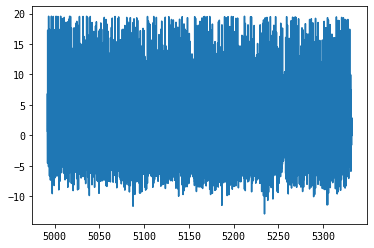

In [159]:
mask_tmp = (df['user'] == 1) & (df['activity'] == 'Walking') & (df['timestamp'] < 5400)
plt.plot(df.loc[mask_tmp, 'timestamp'], df.loc[mask_tmp, 'ax'])

In [166]:
A = np.array([1., 1., 1.])[:, np.newaxis]
proj = np.linalg.svd(A)[0][:, 1:]
proj

array([[-0.57735027, -0.57735027],
       [ 0.78867513, -0.21132487],
       [-0.21132487,  0.78867513]])

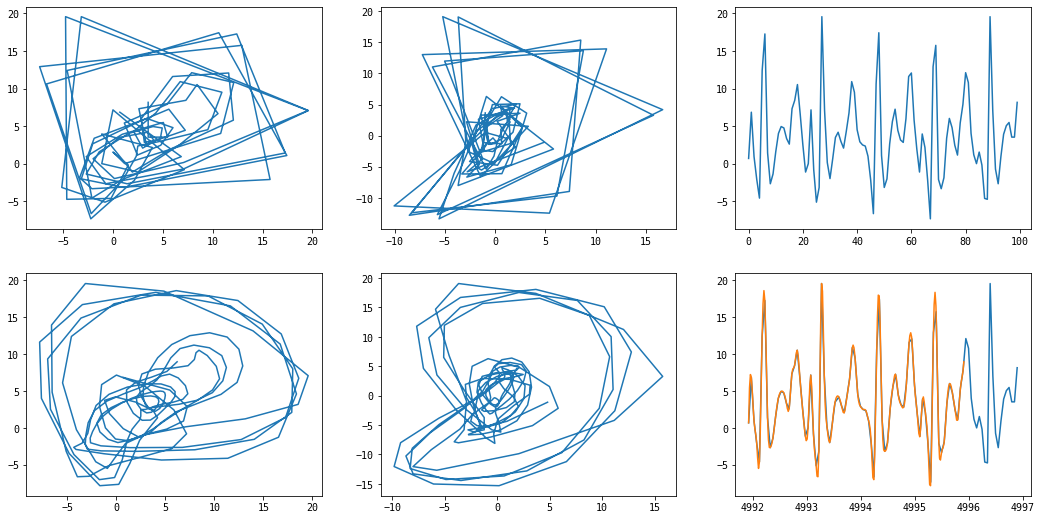

In [193]:
from scipy.interpolate import interp1d

def make(ar, lag):
    result = np.stack([ar[:-2*lag], ar[lag:-lag], ar[2*lag:]]).T
    return result @ proj

tm = df.loc[mask_tmp, 'timestamp'].values[:100]
ser = df.loc[mask_tmp, 'ax'].values[:100]
lag = 1
plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.plot(ser[:-lag], ser[lag:])

plt.subplot(2, 3, 2)
plt.plot(*make(ser, lag).T)

plt.subplot(2, 3, 3)
plt.plot(ser)

f = interp1d(tm, ser, kind='cubic')
tm_new = np.linspace(0, 4, 240, endpoint=False) + tm.min()
ser_new = f(tm_new)

plt.subplot(2, 3, 4)
plt.plot(ser_new[:-3*lag], ser_new[3*lag:])

plt.subplot(2, 3, 5)
plt.plot(*make(ser_new, 3*lag).T)

plt.subplot(2, 3, 6)
plt.plot(tm, ser)
plt.plot(tm_new, ser_new)
plt.show(); plt.close()

(array([449.,   0.,   2.,   0.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([5.00030000e-01, 1.97034631e+04, 3.94064261e+04, 5.91093892e+04,
        7.88123522e+04, 9.85153153e+04, 1.18218278e+05, 1.37921241e+05,
        1.57624204e+05, 1.77327168e+05, 1.97030131e+05]),
 <BarContainer object of 10 artists>)

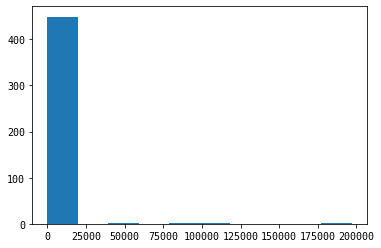

In [151]:
plt.hist( df['timestamp'].diff()[df['timestamp'].diff() > 0.5] )